In [22]:
import numpy
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

### 1. Load Test and Train Files

In [23]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = 'train_data/train'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)


folder = 'train_data/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

(381, 164)


### 2. Set key parameters

In [24]:
img_width, img_height = 48, 48
train_data_dir = "train_data/train"
validation_data_dir = "train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [25]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

In [26]:
x = model.output
x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model
model_final = Model(input = model.input, output = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"]) # See learning rate is very low

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


In [27]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [28]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


In [29]:
### Start training!

history_object = model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=11, epochs=15, callbacks=[<keras.ca..., validation_steps=164)`
  if __name__ == '__main__':


Epoch 1/15
10/11 [==========================>...] - ETA: 0s - loss: 0.6248 - acc: 0.6210
Epoch 00001: val_acc improved from -inf to 0.77449, saving model to car1.h5
11/11 [==============================] - 6s 552ms/step - loss: 0.6193 - acc: 0.6245 - val_loss: 0.4398 - val_acc: 0.7745
Epoch 2/15
 8/11 [====================>.........] - ETA: 0s - loss: 0.4339 - acc: 0.7461
Epoch 00002: val_acc improved from 0.77449 to 0.86131, saving model to car1.h5
11/11 [==============================] - 5s 456ms/step - loss: 0.3886 - acc: 0.7774 - val_loss: 0.3228 - val_acc: 0.8613
Epoch 3/15
 9/11 [=======================>......] - ETA: 0s - loss: 0.2754 - acc: 0.9086
Epoch 00003: val_acc improved from 0.86131 to 0.92204, saving model to car1.h5
11/11 [==============================] - 5s 454ms/step - loss: 0.2646 - acc: 0.9196 - val_loss: 0.2556 - val_acc: 0.9220
Epoch 4/15
10/11 [==========================>...] - ETA: 0s - loss: 0.1922 - acc: 0.9515
Epoch 00004: val_acc did not improve
11/11 [===

['acc', 'loss', 'val_acc', 'val_loss']


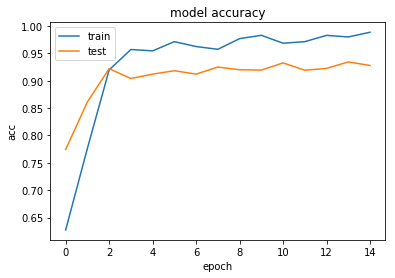

In [30]:
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

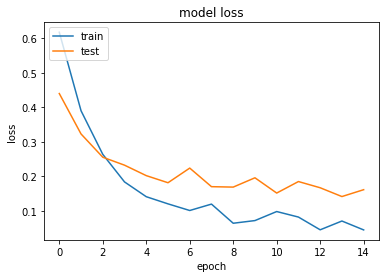

In [31]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()